<a href="https://colab.research.google.com/github/sridevi-bommidi/Image_Classification/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [2]:
import os, shutil, random
import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import joblib

#Mounting drive and Loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_filename = "/content/drive/MyDrive/HAM10000.zip"
with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()
    print("Dataset extracted.")

Dataset extracted.


In [5]:
data_pd = pd.read_csv("/content/drive/MyDrive/HAM10000_metadata.csv")

#Lets understand the data

In [ ]:
## Lets study about the data


print("Top five rows",data_pd.head())
print("number of unique values(dx)",data_pd['dx'].nunique())
print("number of unique values(lesion_id)",data_pd['lesion_id'].nunique())


Top five rows      lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
number of unique values(dx) 7
number of unique values(lesion_id) 7470


 Total number of rows (images): 10015
Number of unique lesion IDs: 7470


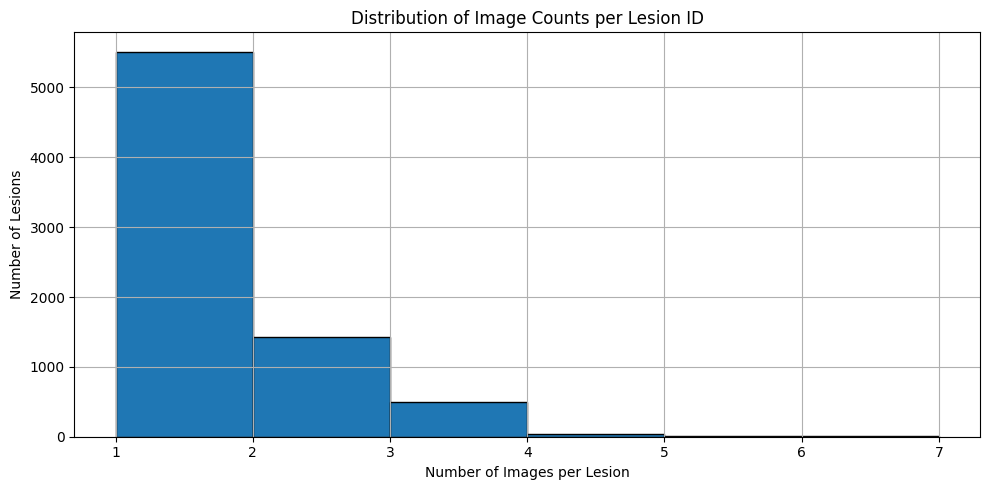

In [ ]:

# 1. Total number of rows
total_rows = len(data_pd)
print(f" Total number of rows (images): {total_rows}")

# 2. Unique lesion IDs
unique_lesions = data_pd['lesion_id'].nunique()
print(f"Number of unique lesion IDs: {unique_lesions}")

# 3. Distribution of image counts per lesion ID
lesion_counts = data_pd['lesion_id'].value_counts()

# Plot
plt.figure(figsize=(10, 5))
plt.hist(lesion_counts.values, bins=range(1, lesion_counts.max()+2), edgecolor='black')
plt.title("Distribution of Image Counts per Lesion ID")
plt.xlabel("Number of Images per Lesion")
plt.ylabel("Number of Lesions")
plt.grid(True)
plt.tight_layout()
plt.show()




The above diagram showcases the number of times images on X-axis and number of lesion_id on y-axis.This means 5,500 lesions have only 1 image and so on.

#Remove Duplicates and split the data

In [6]:
# Remove duplicate lesions: keep only those lesion_ids with a count of 1
df_count = data_pd.groupby('lesion_id').count().reset_index()
df_count = df_count[df_count['dx'] == 1]

def duplicates(x):
    unique = set(df_count['lesion_id'])
    return 'no' if x in unique else 'duplicate'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd = data_pd[data_pd['is_duplicate'] == 'no']

 Total number of rows (images): 5514
Number of unique lesion IDs: 5514


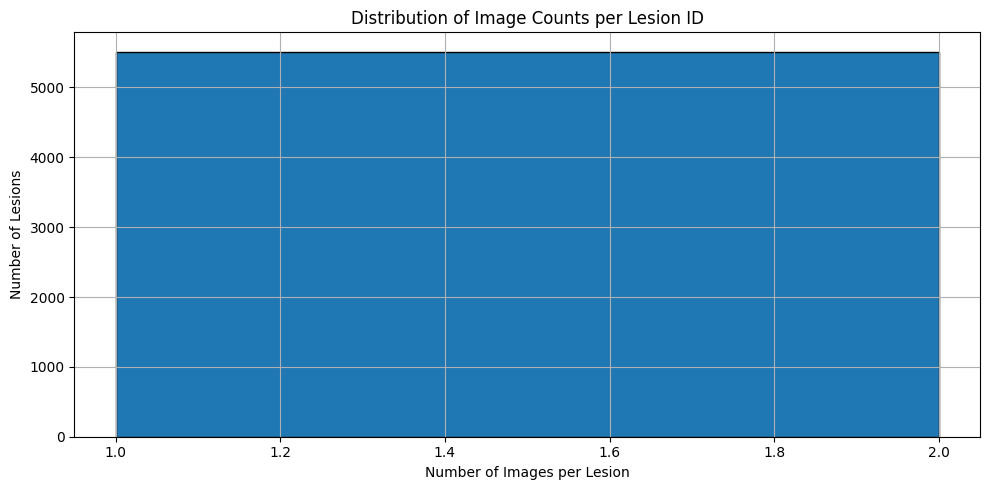

In [7]:

# 1. Total number of rows
total_rows = len(data_pd)
print(f" Total number of rows (images): {total_rows}")

# 2. Unique lesion IDs
unique_lesions = data_pd['lesion_id'].nunique()
print(f"Number of unique lesion IDs: {unique_lesions}")

# 3. Distribution of image counts per lesion ID
lesion_counts = data_pd['lesion_id'].value_counts()

# Plot
plt.figure(figsize=(10, 5))
plt.hist(lesion_counts.values, bins=range(1, lesion_counts.max()+2), edgecolor='black')
plt.title("Distribution of Image Counts per Lesion ID")
plt.xlabel("Number of Images per Lesion")
plt.ylabel("Number of Lesions")
plt.grid(True)
plt.tight_layout()
plt.show()




The above picture shows that there 5514 images for unique 5514 lesion_ids.

In [8]:

train_df, test_df = train_test_split(data_pd, test_size=0.15, stratify=data_pd['dx'], random_state=42)

# Mark images as train or test based on split
def identify_trainOrtest(image_id):
    test_ids = set(test_df['image_id'].astype(str))
    return 'test' if str(image_id) in test_ids else 'train'
# now here we are creating a new column train_test_split which contains 2 unique values train or test and dataframe which contains only train images
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']

# Set image_id as index for easier lookup of labels
data_pd.set_index('image_id', inplace=True)

data_pd = data_pd.drop(columns=['is_duplicate'])

#Creating directories and loading images

In [9]:
base_dir = 'HAM10000'
train_dir = os.path.join(base_dir, 'train_dir')
test_dir = os.path.join(base_dir, 'test_dir')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [10]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for label in targetnames:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Get lists of image IDs for train and test sets
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

# Copy images to the train directories
for image in train_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx']
    source = os.path.join(base_dir, file_name)
    target = os.path.join(train_dir, label, file_name)
    if os.path.exists(source):
        shutil.copyfile(source, target)
    else:
        print("File not found:", source)

# Copy images to the test directories
for image in test_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx']
    source = os.path.join(base_dir, file_name)
    target = os.path.join(test_dir, label, file_name)
    if os.path.exists(source):
        shutil.copyfile(source, target)
    else:
        print("File not found:", source)

print("Images copied to train and test directories.")

Images copied to train and test directories.


#Data Augmentation

In [ ]:
image_size = 224 #this is standard size for cnn models
label_to_index = {label: idx for idx, label in enumerate(targetnames)}

X_train_list = []
y_train_list = []

random.seed(42)
np.random.seed(42)

for label in targetnames:
    class_dir = os.path.join(train_dir, label)
    file_list = os.listdir(class_dir)

    # Sample 500 images (if there are fewer, sample with replacement)
    if len(file_list) >= 500:
        sampled_files = random.sample(file_list, 500)
    else:
        sampled_files = list(np.random.choice(file_list, size=500, replace=True))

    for file in sampled_files:
        img_path = os.path.join(class_dir, file)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        X_train_list.append(img_array)
        y_train_list.append(label_to_index[label])

# Convert lists to numpy arrays and normalize pixel values to [0,1]
X_train = np.array(X_train_list, dtype=np.float32) / 255.0
y_train = np.array(y_train_list)
print("Balanced training set created with {} images.".format(X_train.shape[0]))

Balanced training set created with 3500 images.


Now we created a training set with 7 different classes , each containing 500 images and a total of 3500 images.

In [ ]:
batch_size = 16
test_datagen = ImageDataGenerator(rescale=1./255)

test_batches = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

X_test_list = []
y_test_list = []
for i in range(len(test_batches)):
    X_batch, y_batch = next(test_batches)
    X_test_list.append(X_batch)
    y_test_list.append(y_batch)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
y_test_labels = np.argmax(y_test, axis=1)
print("Test set loaded with {} images.".format(X_test.shape[0]))

Found 828 images belonging to 7 classes.
Test set loaded with 828 images.


Here we made a test dataset using ImageDataGenerator to test the models further.

#Logistic Regression

##Model Building

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

clf = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    max_iter=50,
    verbose=0,
    n_jobs=-1
)
clf.fit(X_train_flat, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=50, multi_class='multinomial', n_jobs=-1,
                   solver='saga')

In [ ]:

# Predict on test data
y_pred = clf.predict(X_test_flat)
accuracy = accuracy_score(y_test_labels, y_pred)
print("\nTest Accuracy: {:.4f}".format(accuracy))



Test Accuracy: 0.6751


- Logistic Regression is a linear model, treating pixel values as independent features.
- Due to high dimensionality (224x224x3), performance is limited compared to deep models.

##Accuracy_LogisticRegression

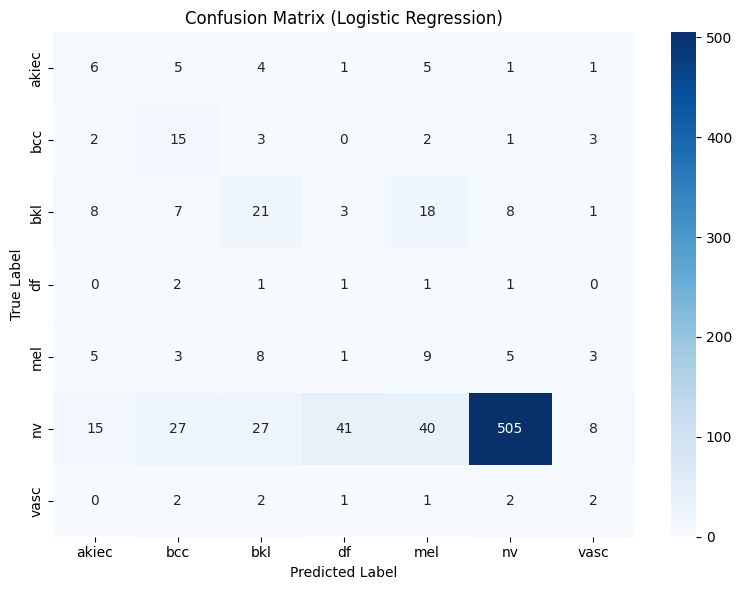

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# If y_test is one-hot encoded, convert it back to label indices
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred

# Now pass to confusion_matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=targetnames, yticklabels=targetnames, cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


- nv has the best performance – 505 correct out of 663 total predictions
- Classes like df, akiec, and mel are hard to distinguish – high confusion with others

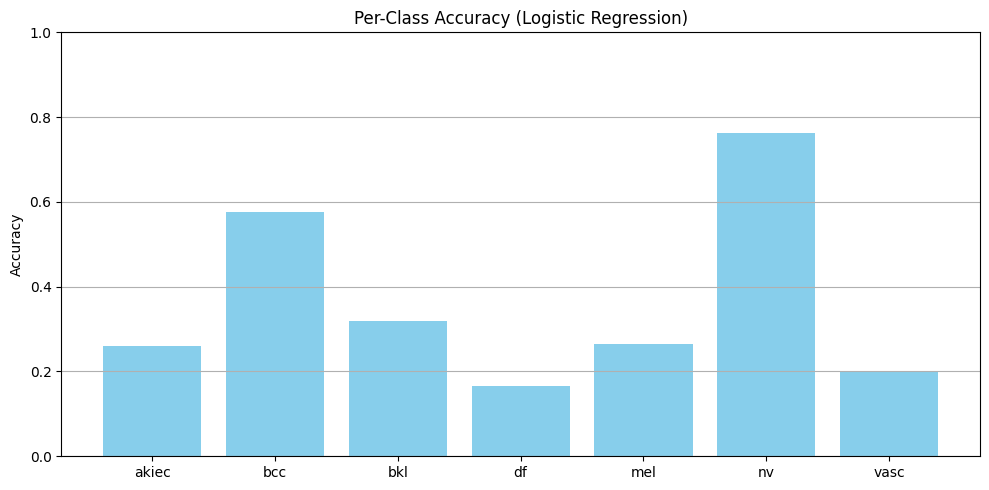

In [ ]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.bar(targetnames, class_accuracy, color='skyblue')
plt.title("Per-Class Accuracy (Logistic Regression)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
train_accuracy = clf.score(X_train_flat, y_train)  # Train accuracy
test_accuracy = clf.score(X_test_flat, y_test_labels)  # Test accuracy

print("Training Accuracy: {:.4f}".format(train_accuracy))
print("Test Accuracy: {:.4f}".format(test_accuracy))


Training Accuracy: 0.8609
Test Accuracy: 0.6751


It is clear that the accuracy on training set is greater than the tesing set defines an overfit.

#Neural Network

##Importing Libraries

In [11]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

##Model Building

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(image_size, image_size, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(len(targetnames), activation='softmax')
])

opt = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"], run_eagerly=True)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      77,070,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,247,367 (294.68 MB)

 Trainable params: 77,245,575 (294.67 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=len(targetnames))
y_test_cat = np.concatenate(y_test_list, axis=0)


from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('T2v.weights.h5', monitor='val_loss', save_weights_only=True,save_best_only=True, mode='min')

- checkpoint saves the best model weights
- early_stop stops early if no improvement
- lr_schedule reduces learning rate if val_accuracy plateaus

In [ ]:

history = model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1, callbacks=[checkpoint, early_stop, lr_scheduler ])

model.load_weights("T2v.weights.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print("\nTest Accuracy: {:.4f}".format(test_accuracy))

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.4515 - loss: 1.5176 - val_accuracy: 0.4541 - val_loss: 1.4531 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.7477 - loss: 0.8542 - val_accuracy: 0.8007 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.8346 - loss: 0.6097 - val_accuracy: 0.0423 - val_loss: 6.1795 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.8977 - loss: 0.4346 - val_accuracy: 0.1401 - val_loss: 2.7928 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9108 - loss: 0.3664 - val_accuracy: 0.0411 - val_loss: 5.3512 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.9471 - loss: 0.2575 - val_accuracy: 0.1087 - val_loss: 3.0794 - learning_rate: 5.0000e-04
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy:

This is where the model is recognised that there is no improvement in val_accuracy after 5 consecutive epochs, so it stopped at 13/20.

##Accuracy_NeuralNetwork

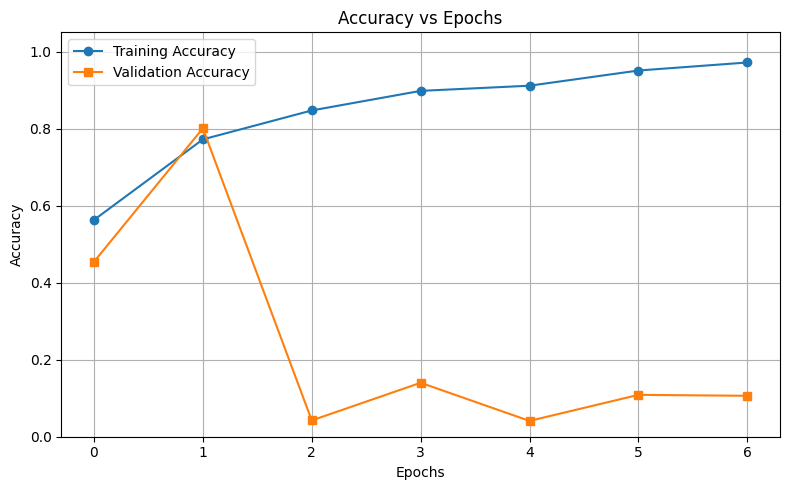

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


we can observe that the model is trained very well but still testing accuracy is lower which indicates overfitting

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


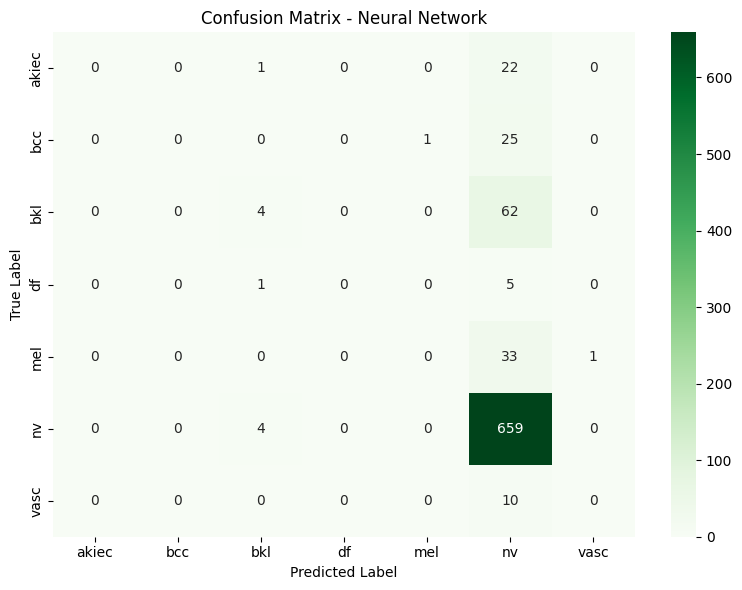

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=targetnames,
            yticklabels=targetnames)
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

we got a better accuracy than logistic regression but still it is similar to that in getting good predictions for nv than others.
- df and vasc are underrepresented, hard to learn — usually confused with nv and others.

#Convonutional Neural Network

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import tensorflow as tf

##Loading images to train and test directories

In [13]:


# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

aug_dir = 'aug_dir'
image_size = 224
max_data = 8000

# Create output directory if it doesn't exist
os.makedirs(aug_dir, exist_ok=True)

# Create label-index mapping (only needed if you wish to keep track of numeric labels)
label_to_index = {label: idx for idx, label in enumerate(targetnames)}

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

for label in targetnames:
    # Create class subfolder in aug_dir
    label_output_dir = os.path.join(aug_dir, label)
    os.makedirs(label_output_dir, exist_ok=True)

    # Get list of images in the original training folder for this label
    class_dir = os.path.join(train_dir, label)
    file_list = os.listdir(class_dir)

    images_for_class = []
    for file_name in file_list:
        img_path = os.path.join(class_dir, file_name)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        images_for_class.append(img_array)

    # Convert list to array
    X_all = np.array(images_for_class, dtype=np.float32)

    n_images = len(X_all)

    # ---------------------------
    # CASE 1: If more than max_data
    # ---------------------------
    if n_images > max_data:
        # Randomly sample max_data images
        selected_indices = random.sample(range(n_images), max_data)
        X_selected = X_all[selected_indices]

        # Save these 2000 (randomly selected) images to aug_dir
        for i, img_array in enumerate(X_selected):
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)

        print(f"Saved {max_data} images (random sample) for class '{label}'.")

    # ---------------------------
    # CASE 2: If fewer than max_data
    # ---------------------------
    elif n_images < max_data:
        # Save all existing images first
        for i, img_array in enumerate(X_all):
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)

        # Now figure out how many augmented images are needed
        needed = max_data - n_images

        # Create a small generator for augmentation
        gen = datagen.flow(X_all, batch_size=1, shuffle=True)

        # Generate and save the augmented images
        for i in range(needed):
            X_aug = next(gen)[0]  # gen outputs a batch of 1, shape (1, H, W, C)
            out_path = os.path.join(label_output_dir, f'aug_{i}.jpg')
            save_img(out_path, X_aug)

        print(f"Saved {n_images} original + {needed} augmented images for class '{label}' (total {max_data}).")

    # ---------------------------
    # CASE 3: Exactly max_data
    # ---------------------------
    else:  # n_images == max_data
        for i, img_array in enumerate(X_all):
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)

        print(f"Exactly {max_data} images found for class '{label}', all saved with no augmentation.")

print("Augmented dataset successfully created in:", aug_dir)


Saved 128 original + 7872 augmented images for class 'akiec' (total 8000).
Saved 149 original + 7851 augmented images for class 'bcc' (total 8000).
Saved 374 original + 7626 augmented images for class 'bkl' (total 8000).
Saved 33 original + 7967 augmented images for class 'df' (total 8000).
Saved 196 original + 7804 augmented images for class 'mel' (total 8000).
Saved 3752 original + 4248 augmented images for class 'nv' (total 8000).
Saved 54 original + 7946 augmented images for class 'vasc' (total 8000).
Augmented dataset successfully created in: aug_dir


we have created aug_dir directory and made 7 classes of each containing 8000 images. Accuracy will be better when we have more data for CNN. So we generated random pictures by zooming in and rotating them to make 8000 images for each class.

In [14]:
batch_size = 16
image_size = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    aug_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 56000 images belonging to 7 classes.
Found 828 images belonging to 7 classes.


##Model BUilding

In [ ]:

cnn_model = Sequential([
    Input(shape=(image_size, image_size, 3)),

    # Block 1
    Conv2D(64, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    Conv2D(128, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 3
    Conv2D(256, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Classification
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(targetnames), activation='softmax', dtype='float32')
])



cnn_opt=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.9)
cnn_model.compile(optimizer=cnn_opt,loss='categorical_crossentropy',metrics=['accuracy'])

- So we build a CNN model with keeping padding as 'same' that means it keeps the output same size as input
- BatchNOrmalization, which normalizes the output from conv2D layer before activation funtion,helps in speed training
- MaxPooling2D which reduces spatial size (height × width),extracts only important features from the image.
- Dropout(0.5) randomly disables 50% of neurons during training, helps in preventing overfitting.

In [ ]:
cnn_checkpoint = ModelCheckpoint('Best_CNN.weights.h5', monitor='val_accuracy', save_weights_only=True,save_best_only=True, mode='max')


In [ ]:
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=35,
    callbacks=[cnn_checkpoint],
    verbose=1
)


Epoch 1/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 103s 25ms/step - accuracy: 0.4934 - loss: 1.6638 - val_accuracy: 0.6801 - val_loss: 1.2220
Epoch 2/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.6600 - loss: 1.1888 - val_accuracy: 0.5711 - val_loss: 1.4787
Epoch 3/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.7096 - loss: 1.0142 - val_accuracy: 0.4645 - val_loss: 1.9383
Epoch 4/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.7417 - loss: 0.9023 - val_accuracy: 0.6532 - val_loss: 1.1954
Epoch 5/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.7720 - loss: 0.8132 - val_accuracy: 0.6679 - val_loss: 1.1827
Epoch 6/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 88s 25ms/step - accuracy: 0.7890 - loss: 0.7460 - val_accuracy: 0.6912 - val_loss: 1.1349
Epoch 7/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.8048 - loss: 0.6856 - val_accuracy: 0.7855 - val_loss: 0.8540
Epoch 8/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 87s 25ms/step - accuracy: 0.8206 

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.5882 - loss: 1.9276

✅ Final Test Accuracy: 0.7802


##Acuuracy_CNN

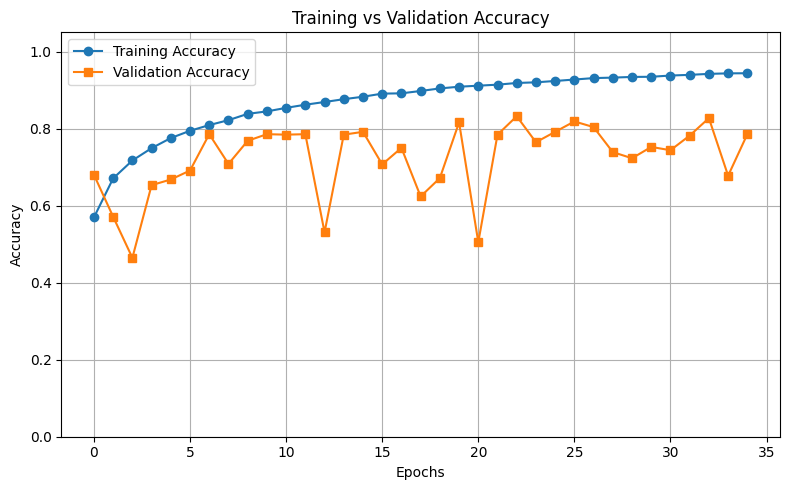

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# gets models probabilities
y_pred_probs = cnn_model.predict(test_generator)

# Convert to class indices
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true_labels = test_generator.classes


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step


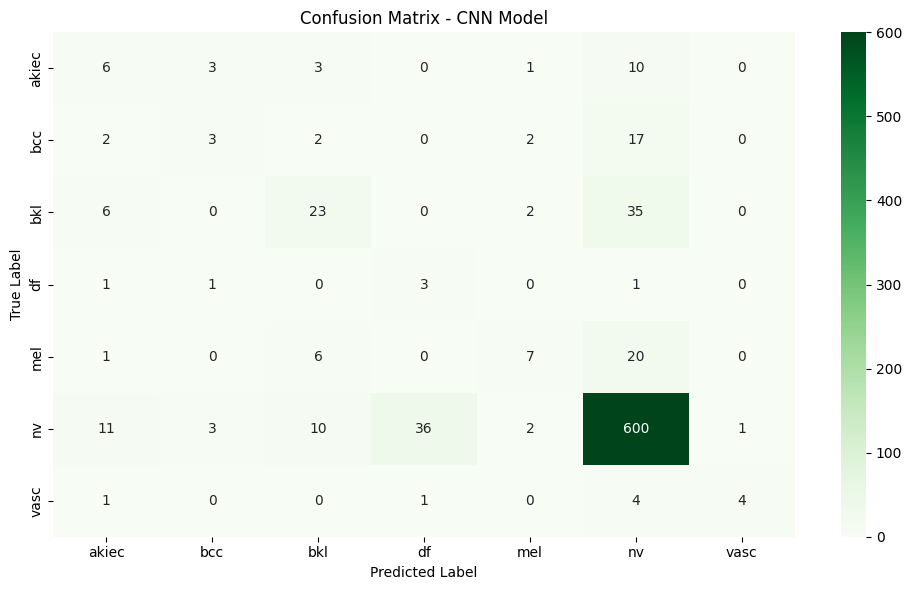

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate confusion matrix
cm_cnn = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


#ResNet-50

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


##Model Building

In [16]:

# Example: Using 'imagenet' weights and adding a few custom layers
# (Set weights=None if you want to train from scratch)
image_size = 224
resnt_model = ResNet50(
    input_shape=(image_size, image_size, 3),
    include_top=False,
    weights='imagenet'  # or None for training from scratch
)

# Add our classification head on top of the ResNet base

x = GlobalAveragePooling2D()(resnt_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(targetnames), activation='softmax')(x)

model_resnet = Model(inputs=resnt_model.input, outputs=predictions)


opt2 = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=0.9)
model_resnet.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()

test_loss, test_accuracy = model_resnet.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,703,367 (94.24 MB)

 Trainable params: 24,650,247 (94.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.0139 - loss: 1.8959

✅ Final Test Accuracy: 0.0072


In [17]:
checkpoint = ModelCheckpoint('Best_R50.weights.h5', monitor='val_accuracy', save_weights_only=True,save_best_only=True, mode='max')


In [18]:
history_res = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=35,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 182s 36ms/step - accuracy: 0.6849 - loss: 0.8301 - val_accuracy: 0.8100 - val_loss: 0.6887
Epoch 2/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 126s 36ms/step - accuracy: 0.9499 - loss: 0.1479 - val_accuracy: 0.8603 - val_loss: 0.5065
Epoch 3/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 125s 36ms/step - accuracy: 0.9774 - loss: 0.0671 - val_accuracy: 0.8566 - val_loss: 0.7134
Epoch 4/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 126s 36ms/step - accuracy: 0.9863 - loss: 0.0421 - val_accuracy: 0.8640 - val_loss: 0.6045
Epoch 5/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 127s 36ms/step - accuracy: 0.9890 - loss: 0.0345 - val_accuracy: 0.8689 - val_loss: 0.8542
Epoch 6/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 125s 36ms/step - accuracy: 0.9938 - loss: 0.0197 - val_accuracy: 0.8603 - val_loss: 0.7203
Epoch 7/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 125s 36ms/step - accuracy: 0.9940 - loss: 0.0191 - val_accuracy: 0.8762 - val_loss: 0.8025
Epoch 8/35
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 123s 35ms/step - accuracy: 

In [22]:

test_loss, test_accuracy = model_resnet.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7212 - loss: 2.3567

✅ Final Test Accuracy: 0.8744


##Accuracy_ResNet-50

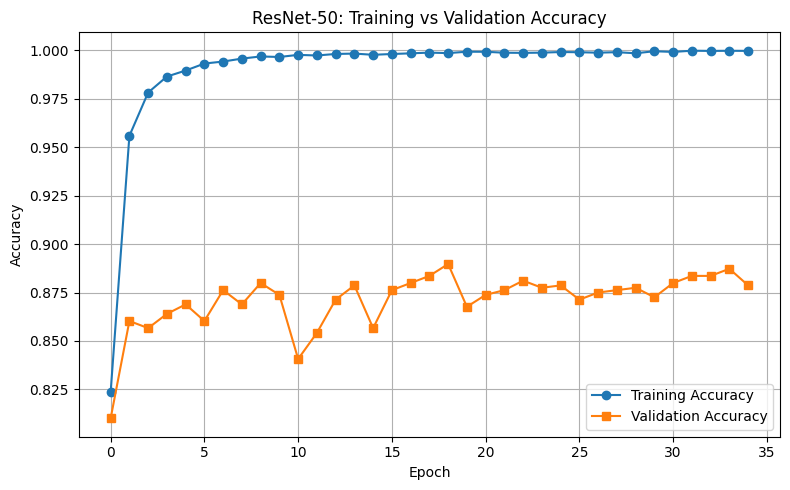

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_res.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_res.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('ResNet-50: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- The model is performing well on training data and also validation accuracy is high.Even with little fluctuations,still the generalisation is good.

In [20]:
import numpy as np

y_pred_probs = model_resnet.predict(test_generator)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = test_generator.classes


52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step


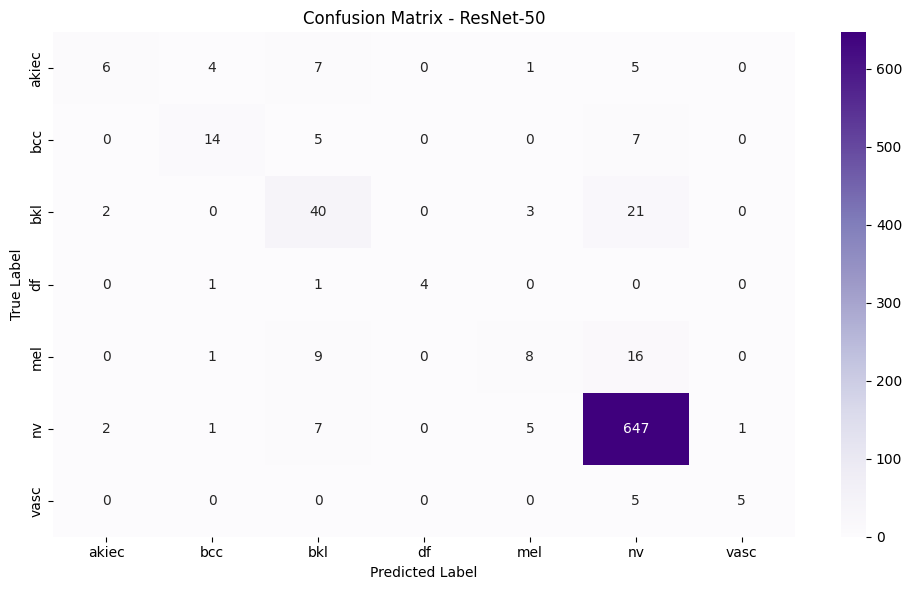

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix - ResNet-50")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


- Logistic Regression was an interpretable, simple baseline but wasn't able to discover useful patterns in high-dimensional image data and had poor accuracy with weak class separation.

- The Fully Connected Neural Network was better than logistic regression but underperformed because it was unable to learn spatial features in images. It performed slightly better but quickly plateaued in accuracy.

- The Custom CNN learned spatial hierarchies more effectively, with a radical improvement in training accuracy. However, it suffered from overfitting, with a validation accuracy of 78%, and confusion matrix results indicating confusion of rare classes.

- Overall best was the ResNet-50 Transfer Learning model with 87% validation accuracy. It generalized well, converged quickly, and also had better class-wise accuracy, especially for the majority class nv.